## Dataset

In [1]:
import json
import os

def print_captions_for_image(image_names_file):
    file_path = r'E:\\MScoco\\annotations\\captions_train2017.json'
    
    # Load the JSON data from the file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Read the image names from the provided text file
    with open(image_names_file, 'r') as file:
        # Read lines and remove any leading or trailing whitespace
        image_names = [line.strip() for line in file.readlines()]

    num_images = len(image_names)  # Count the number of images

    # Construct the output file name with the number of images
    output_file_name = f"Part2_{num_images}.txt"
    captions_output_file = os.path.join(r"E:\MScoco\Review\ImageNames", output_file_name)

    # Open the output file to write captions
    with open(captions_output_file, 'w') as out_file:
        for image_name in image_names:
            # Clean up the image name
            cleaned_image_name = image_name.strip().replace('\'', '').replace('"', '')

            # Find the image ID corresponding to the given image name
            image_id = None
            for image in data['images']:
                if image['file_name'] == cleaned_image_name:
                    image_id = image['id']
                    break
            
            # If the image ID was found, write the image name and its captions, otherwise print a message
            if image_id is not None:
                out_file.write(f'{cleaned_image_name}\n')  # Write the image name
                captions = [annotation['caption'] for annotation in data['annotations'] if annotation['image_id'] == image_id]
                for caption in captions:
                    out_file.write(f'{caption}\n')
                out_file.write('\n')  # Add an extra newline for separation between different images
            else:
                print(f'No captions found for image: {cleaned_image_name}')



# Example usage
image_names_file = r"E:\MScoco\Review\ImageNames\SinaFile\name_2k_ta_7k_3493.txt"
print_captions_for_image(image_names_file)


In [1]:
import json
import pandas as pd
import numpy as np

def print_captions_for_image(image_name):# get the image name

    file_path = r'E:\\MScoco\\annotations\\captions_train2017.json'
    # Load the JSON data from the file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Find the image ID corresponding to the given image name
    image_id = None
    for image in data['images']:
        if image['file_name'] == image_name:
            image_id = image['id']
            break
    
    # If the image ID was found, print all captions associated with this image
    if image_id is not None:
        print(f'Captions for {image_name}:')
        captions = [annotation['caption'] for annotation in data['annotations'] if annotation['image_id'] == image_id]
        for i, caption in enumerate(captions, start=1):
            print(f'Caption {i}: {caption}')
    else:
        print(f'No captions found for image: {image_name}')


In [9]:
print_captions_for_image('000000000764.jpg')

Captions for 000000000764.jpg:
Caption 1: an image  of people outside playing frisbee
Caption 2: a crowded field with a woman throwing a frisbee in the foreground
Caption 3: A bunch of people playing with a Frisbee in a park.
Caption 4: The large group of people are playing Frisbee in the park. 
Caption 5: A woman in brown jacket throwing a yellow frisbee.


## Open Mat file

In [1]:
import scipy.io
import numpy as np

def process_mat_file(file_path):
    # Load .mat file
    mat = scipy.io.loadmat(file_path)
    
    # Accessing the data stored under the 'result' key
    result_data = mat['result']
    
    # Accessing the 'best_solution' field within the 'result' dictionary
    best_solution_array = result_data['best_solution']
    
    # Extracting the inner array
    best_solution_inner_array = best_solution_array[0]
    
    # Extracting the actual data from the inner array
    best_solution_data = best_solution_inner_array[0]
    
    # Reshape the data to a 10x10 matrix
    best_solution_matrix = best_solution_data.reshape(10, 10)
    
    # Check the size of the resized matrix
    print("Size of the resized matrix:", best_solution_matrix.shape)
    
    # Save the matrix as a binary file
    np.save('WeightNewHyperPar_1000_10x10.npy', best_solution_matrix)



In [2]:
# Example usage:
process_mat_file(r"E:\MScoco\Review\WeightNewHyperPar_1000_10x10.mat")

Size of the resized matrix: (10, 10)


## Recall

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def calculate_recall_and_print(image_path, text_path, best_solution_matrix_path,index_label):
    # Load the best solution matrix
    best_solution_matrix = np.load(best_solution_matrix_path)
    
    # Load the image and text datasets
    image_df = pd.read_csv(image_path)
    text_df = pd.read_csv(text_path)
    
    # Assuming the first columns before the last two are the feature vectors
    image_features = image_df.iloc[:, :-2].values
    text_features = text_df.iloc[:, :-3].values
    
    # Transform both image and text features by the weights matrix
    transformed_image_features = np.dot(image_features, best_solution_matrix)
    transformed_text_features = np.dot(text_features, best_solution_matrix)
    
    # Calculate cosine similarity
    cosine_sim = cosine_similarity(transformed_image_features, transformed_text_features)
    
    # Print the size of the datasets
    print("Size of image dataset:", image_features.shape)
    print("Size of text dataset:", text_features.shape)
    print('Size of best solution matrix:', best_solution_matrix.shape)
    
    # Function to calculate recall
    def calculate_recall_for_K(K):
        ranked_indices = np.argsort(-cosine_sim, axis=1)[:, :K]
        hits = 0

        for i in range(len(image_df)):
            image_label = image_df.iloc[i, index_label]  # Adjust index as per your dataset
            relevant_text_indices = text_df.index[text_df.iloc[:, index_label] == image_label].tolist()
            top_k_indices = ranked_indices[i, :K]
            
            # Check if there's at least one relevant item in top K
            if any(idx in top_k_indices for idx in relevant_text_indices):
                hits += 1

        recall = hits / len(image_df)
        return recall

    # List of K values to calculate recall for
    K_values = [1,5,10]

    # Calculate and print recall for each K
    for K in K_values:
        recall = calculate_recall_for_K(K)
        # Format recall as a percentage with one decimal place
        print(f"Recall@{K}: {recall:.1%}")



In [5]:
# Example usage:
image_path=r"E:\MScoco\R@K\full\NewTest\new_100_img_pca_10.csv"
text_path=r"E:\MScoco\R@K\full\NewTest\new_100_Text_pca_10.csv"
best_solution_matrix_path=r"E:\MScoco\Review\WeightNewHyperPar_1000_10x10.npy"
calculate_recall_and_print(image_path,text_path,best_solution_matrix_path,10)


Size of image dataset: (234, 10)
Size of text dataset: (347, 10)
Size of best solution matrix: (10, 10)
Recall@1: 35.5%
Recall@5: 47.0%
Recall@10: 51.3%


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_the_w(image_path, text_path, best_solution_matrix_path):
    # Load the best solution matrix
    best_solution_matrix = np.load(best_solution_matrix_path)
    
    # Load the image and text datasets
    image_df = pd.read_csv(image_path)
    text_df = pd.read_csv(text_path)
    
    # Assuming the first columns before the last two are the feature vectors
    image_features = image_df.iloc[:, :-2].values
    text_features = text_df.iloc[:, :-3].values
    
    # Transform both image and text features by the weights matrix
    transformed_image_features = np.dot(image_features, best_solution_matrix)
    transformed_text_features = np.dot(text_features, best_solution_matrix)
    
    # Plot original image and text features in 2D
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(image_features[:, 0], image_features[:, 1], c='blue', label='Image Features')
    plt.scatter(text_features[:, 0], text_features[:, 1], c='red', label='Text Features')
    plt.title('Source Space')
    #plt.xlabel('Feature 1')
    #plt.ylabel('Feature 2')
    plt.legend()
    
    # Plot transformed image and text features in 2D
    plt.subplot(1, 2, 2)
    plt.scatter(transformed_image_features[:, 0], transformed_image_features[:, 1], c='blue', label='Transformed Image Features')
    plt.scatter(transformed_text_features[:, 0], transformed_text_features[:, 1], c='red', label='Transformed Text Features')
    plt.title('Target Space')
    #plt.xlabel('Feature 1')
    #plt.ylabel('Feature 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



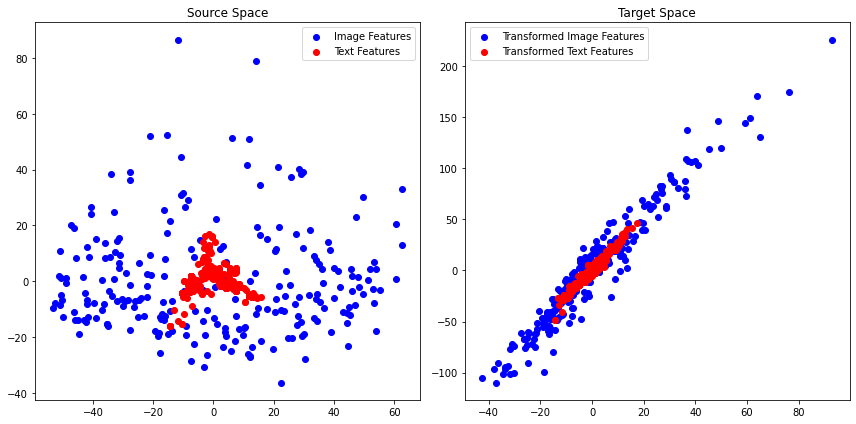

In [6]:
image_path=r"E:\MScoco\R@K\full\NewTest\new_100_img_pca_10.csv"
text_path=r"E:\MScoco\R@K\full\NewTest\new_100_Text_pca_10.csv"
best_solution_matrix_path=r"E:\MScoco\Review\WeightNewHyperPar_1000_10x10.npy"
plot_the_w(image_path,text_path,best_solution_matrix_path)

In [11]:
def plot_the_w2(image_path, text_path, best_solution_matrix_path, index_label):
    # Load the best solution matrix
    best_solution_matrix = np.load(best_solution_matrix_path)
    
    # Load the image and text datasets
    image_df = pd.read_csv(image_path)
    text_df = pd.read_csv(text_path)
    
    # Assuming the first columns before the last two are the feature vectors
    image_features = image_df.iloc[:, :-2].values
    text_features = text_df.iloc[:, :-3].values
    
    # Transform both image and text features by the weights matrix
    transformed_image_features = np.dot(image_features, best_solution_matrix)
    transformed_text_features = np.dot(text_features, best_solution_matrix)
    
    # Extract labels
    image_labels = image_df.iloc[:, index_label].values
    text_labels = text_df.iloc[:, index_label].values
    
    # Generate a color map
    unique_labels = np.unique(np.concatenate((image_labels, text_labels)))
    cmap = plt.get_cmap('tab10')
    label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}
    
    # Define marker shapes
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']
    label_to_marker = {label: markers[i % len(markers)] for i, label in enumerate(unique_labels)}
    
    # Plot original image and text features in 2D
    plt.figure(figsize=(14, 7))
    
    plt.subplot(1, 2, 1)
    for label in unique_labels:
        image_mask = image_labels == label
        text_mask = text_labels == label
        plt.scatter(image_features[image_mask, 0], image_features[image_mask, 1], 
                    c=[label_to_color[label]], marker=label_to_marker[label], edgecolor='k', label=f'Image {label}')
        plt.scatter(text_features[text_mask, 0], text_features[text_mask, 1], 
                    c=[label_to_color[label]], marker=label_to_marker[label], edgecolor='k', label=f'Text {label}', alpha=0.7)
    plt.title('Original Image and Text Features')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='best')
    
    # Plot transformed image and text features in 2D
    plt.subplot(1, 2, 2)
    for label in unique_labels:
        image_mask = image_labels == label
        text_mask = text_labels == label
        plt.scatter(transformed_image_features[image_mask, 0], transformed_image_features[image_mask, 1], 
                    c=[label_to_color[label]], marker=label_to_marker[label], edgecolor='k', label=f'Transformed Image {label}')
        plt.scatter(transformed_text_features[text_mask, 0], transformed_text_features[text_mask, 1], 
                    c=[label_to_color[label]], marker=label_to_marker[label], edgecolor='k', label=f'Transformed Text {label}', alpha=0.7)
    plt.title('Transformed Image and Text Features')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

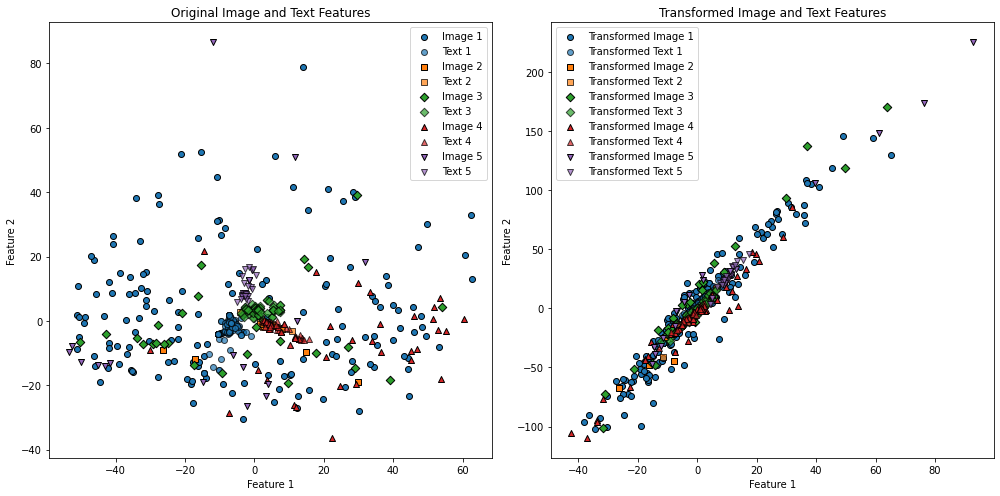

In [12]:
image_path=r"E:\MScoco\R@K\full\NewTest\new_100_img_pca_10.csv"
text_path=r"E:\MScoco\R@K\full\NewTest\new_100_Text_pca_10.csv"
best_solution_matrix_path=r"E:\MScoco\Review\WeightNewHyperPar_1000_10x10.npy"
plot_the_w2(image_path,text_path,best_solution_matrix_path,10)